# TP 1 - Reinforcement Learning (November 16rd)

Name: Diego Andres Torres Guarin

### Instructions
This assignement will be a discovery of a library for working with RL problems,   an implementation of Policy Iteration and Value Iteration algorithm and the first implementation of a sampling-based algorithm.

We used the Cliff Walking Environment (also from Sutton's book).

    Adapted from Example 6.6 (page 132) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center
    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.

![ChessUrl](https://gymnasium.farama.org/_images/cliff_walking.gif "Cliff Walking")

- Save this notebook in a ```.ipynb``` format and send it to cyriaque.rousselot(at)inria(dot)fr with the name ```TP1_NAME_SURNAME``` before November 23th.
- Make sure to comment your code and explain your decisions clearly. Write explanations in text if necessary 
- Answers must be short and precise and don't require thousands lines of code. 
- Generally, the code to complete is indicated with the comment ```#TO IMPLEMENT```
Good luck !


## A gentle start with Gymnasium

Have a look at the documentation of gymnasium https://gymnasium.farama.org/content/basic_usage/, of environments https://gymnasium.farama.org/api/env/ and of the Cliff Walking Environment https://gymnasium.farama.org/environments/toy_text/cliff_walking/. 


> You can use multiple render_mode in a gym environment class. For simplicity, I will ask you to render the environment in ansi mode to display it in the notebook.

**Q.1 Display the Action Space / State space of the CliffWalking environment**

In [3]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 320 µs (started: 2023-11-18 15:33:54 +01:00)


In [4]:
import numpy as np
import gymnasium as gym
from matplotlib import pyplot as plt
import time 

print("="*10 + "Load the environment"+"="*10)
env = gym.make('CliffWalking-v0', render_mode="ansi") # Initialize the environment object
observation, info = env.reset(seed=42) # Reset the environment

print("="*10 + "Visualize the environment"+"="*10)
print(env.render()) # The Cliff Walking Environment in ANSI 

## Action Space
nb_actions = 4
print("="*10 + "Action Space"+"="*10)
print(env.action_space)
print('There are 4 actions: 0 = Up, 1 = Right, 2 = Down, 3 = Left')

## State space
nb_states = 48
print("="*10 + "State Space"+"="*10)
print(env.observation_space)
print("""There are 48 states: 0 to 47. 
The state 36 is the starting point, and the state 47 is the goal. 
The states 37 to 46 are the cliff.""")
env.close()

==========Load the environment==========
==========Visualize the environment==========
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T


==========Action Space==========
Discrete(4)
There are 4 actions: 0 = Up, 1 = Right, 2 = Down, 3 = Left
==========State Space==========
Discrete(48)
There are 48 states: 0 to 47. 
The state 36 is the starting point, and the state 47 is the goal. 
The states 37 to 46 are the cliff.
time: 696 ms (started: 2023-11-18 15:33:54 +01:00)


### Use of a random policy

**Q.2 Implement a policy that chose an action randomly from the action space and a policy that chose always the action "go right"**

In [5]:
def RandomPolicy(state, action_space):
    return np.random.randint(action_space.n)


def GoRightPolicy(state, action_space):
    return 1

time: 435 µs (started: 2023-11-18 15:33:55 +01:00)


**Q.3 What is the meaning of the ouptut of the method ```step()``` of the environment class ?**

In [6]:
env = gym.make('CliffWalking-v0',render_mode="ansi")
env.reset()
print(env.step(2))
env.close()

(36, -1, False, False, {'prob': 1.0})
time: 8.09 ms (started: 2023-11-18 15:33:55 +01:00)


**Answers**

1. The first entry in the output is the new state. In this particular case we tried to move down from the initial state, which is not possible because there is no available square below this position. Hence the returned position is the same. 
2. The second entry is the reward. As we didn't get to the goal but a timestep passed, we get the negative reward of -1.
3. The third entry is the flag to indicate whether a terminal state has been reached. 
4. The fourth entry tells you if the episode has been truncated because it reached the maximum length.
5. The dictionary generally contains extra information that might be relevant. In this case it indicates that the probability of going to the new state is 1, as this is a deterministic environment.

**Q.4 Build a function ```transition(env,s1,Pi)``` that take in entry the environment, a state and a ```policy(state,action_space)``` function. It has to return the immediate reward, the next state and a boolean that indicates if the next step is a terminal state.**

In [7]:
def transition(env, s1, Pi):
    action = Pi(s1, env.action_space)
    s2, reward, done, _, _ = env.step(action)
    return reward, s2, done


env = gym.make('CliffWalking-v0', render_mode='ansi')
s0 = env.reset()[0]
print(transition(env, s0, RandomPolicy))
env.close()

(-100, 36, False)
time: 7.3 ms (started: 2023-11-18 15:33:55 +01:00)


**Q.5 Build a function ```SimulateTrajectory(T,policy)``` that simulate the behavior of an agent that start at an initial state, chose its next states using ```policy(state,action_space)``` function and keep trace of the state visited and the rewards obtained. It stops after ```T``` steps or if it encounters a terminal state. Use this function to plot the Cumulated Discounted Reward for multiple initialisations**
>(Hint: you can use the function defined in question Q.4)

In [64]:
def SimulateTrajectory(T, policy):
    """return a vector of T successive states and a vector of T successive immediate rewards"""
    s , _ = env.reset()

    states = [s]
    rewards = []
    for t in range(T):
        r, s, done = transition(env, s, policy)
        states.append(s)
        rewards.append(r)
        if done:
            break

    return states, rewards


gamma = 0.9  # discount factor
# truncation of the infinite sum
T = int(np.log(1/(0.001*(1-gamma)))/np.log(1/gamma))


time: 940 µs (started: 2023-11-18 16:21:11 +01:00)


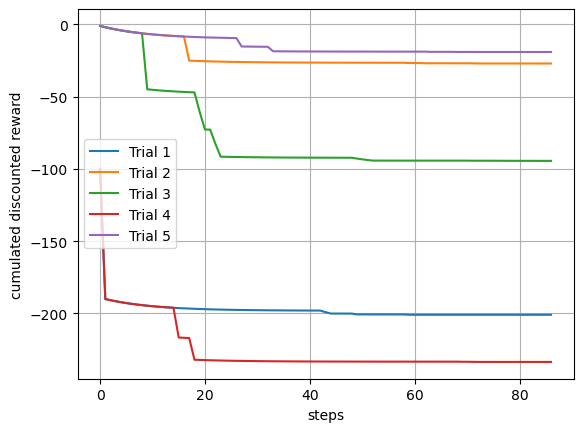

time: 227 ms (started: 2023-11-18 16:22:48 +01:00)


In [77]:
np.random.seed(10)
for _ in range(5):
    States1, Rewards1 = SimulateTrajectory(T, RandomPolicy)
    plt.plot(np.cumsum(Rewards1*np.array([gamma**t for t in range(len(Rewards1))])), label=f"Trial {_+1}")

plt.xlabel('steps')
plt.ylabel('cumulated discounted reward')
plt.legend()
plt.grid()
plt.show()

**Q.6 Implement the optimal policy and display a corresponding trajectory from the initial state.**

In [9]:
def OptimalPolicy(state, action_space):
    if state == 36:
        return 0
    elif state == 35:
        return 2
    else:
        return 1

time: 572 µs (started: 2023-11-18 15:33:56 +01:00)


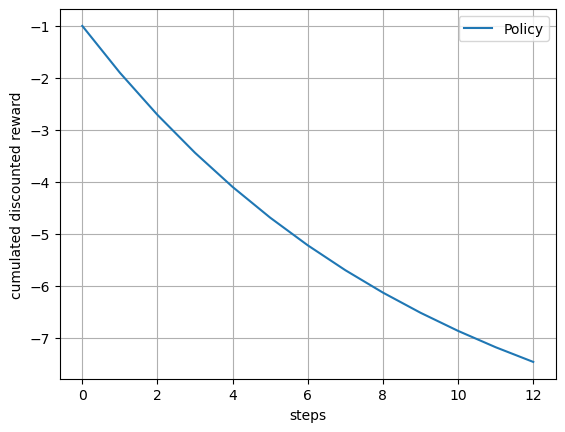

time: 208 ms (started: 2023-11-18 16:22:58 +01:00)


In [78]:
states, rewards = SimulateTrajectory(T, OptimalPolicy)

plt.figure()
plt.plot(np.cumsum(rewards*np.array([gamma**t for t in range(len(rewards))])), label="Policy")

plt.xlabel('steps')
plt.ylabel('cumulated discounted reward')
plt.legend()
plt.grid()
plt.show()

# Dynamic Programming

In order to use our dynamic programming algorithms, we need to know the parameters of the MDP. 
Here we know the reward and transition model. 

**Q.7 Fill the reward array ```r[s,a]```, the transition array ```p[s,a,s']``` and the terminal array ```T[s]``` that return a boolean if the state is terminal.**


> Hint : You can look at https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py

In [95]:
# Can be useful
# Convert a state number into its coordinates on the grid.
def number_to_grid(x):
    return (np.unravel_index(np.array(x), shape=(4, 12)))


def grid_to_number(x):
    return (np.ravel_multi_index(x, (4, 12)))


# MDP parameters
nb_states = 48
nb_actions = 4
P = np.zeros((nb_states, nb_actions, nb_states))  # P[s,a,s'] = p(s' | s,a)
# r[s,a] =  reward received in state s when playing action a
r = np.zeros((nb_states, nb_actions))
T = np.zeros((nb_states,))  # T[s] = True if state is terminal, False otherwise

time: 1.21 ms (started: 2023-11-18 16:43:55 +01:00)


In [96]:
# Fill the transition matrix
for a in range(nb_actions):
    for s in range(nb_states):
        x, y = number_to_grid(s)
        if a == 0:
            x = max(0, x-1)
        elif a == 1:
            y = min(11, y+1)
        elif a == 2:
            x = min(3, x+1)
        else:
            y = max(0, y-1)

        s_prime = grid_to_number((x, y))

        if  36 < s_prime < 47:
            s_prime = 36
            
        P[s, a, s_prime] = 1

time: 6 ms (started: 2023-11-18 16:43:55 +01:00)


In [97]:
# Up
r[:, 0] = -1

# Right
r[:, 1] = -1 
r[36:-2, 1] = -100
r[-2:, 1] = 0

# Down
r[:, 2] = -1
r[25:35, 2] = -100
r[37:-1, 2] = -100
r[-1, 2] = 0
r[35, 2] = 0

# Left
r[:, 3] = -1
r[38:, 3] = -100

time: 770 µs (started: 2023-11-18 16:43:56 +01:00)


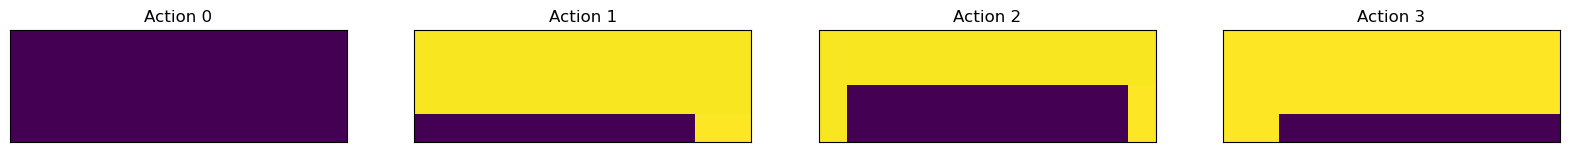

time: 210 ms (started: 2023-11-18 16:43:56 +01:00)


In [98]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for a in range(nb_actions):
    axs[a].imshow(r[:, a].reshape(4, 12))
    axs[a].set_title("Action {}".format(a))
    axs[a].set_xticks([])
    axs[a].set_yticks([])

In [99]:
# Fill the T vector 
T[-1] = 1

time: 307 µs (started: 2023-11-18 16:43:57 +01:00)


In [100]:
# sampling method for next state given current state and action
def sample_next_state(P, s, a):
    return np.random.choice(range(nb_states), 1, p=P[s, a])[0]

time: 486 µs (started: 2023-11-18 16:43:59 +01:00)


### Policy Iteration

In this section, we will consider deterministic policies. A deterministic policy  is represented as a vector pi[s] with s a state. 

In [17]:
# An example of random deterministic policy
example_pi = np.random.choice([0, 1, 2, 3], nb_states)

time: 563 µs (started: 2023-11-18 15:33:58 +01:00)


In [18]:
state = 13
print(f"The action from state {state} is {example_pi[state]}")

The action from state 13 is 3
time: 415 µs (started: 2023-11-18 15:33:58 +01:00)


**Q.8 Using the Bellman equations, build a function for evaluating the state-value function $V_\pi$ of a policy $\pi$ iteratively. We consider convergence with $\epsilon = 0.01$ or if we performed a maximum of 10000 iterations.**
> Hint : you can look at Sutton & Barto , Reinforcement Learning, An introduction, chapter 4

In [19]:
epsilon = 0.01
max_iter = 10000


def policy_evaluation(policy, epsilon, gamma, max_iter):
    V = np.zeros(nb_states)  # intialize Values to 0's

    delta = 0
    for _ in range(max_iter):
        for s in range(nb_states):
            v = V[s]
            if T[s] == 1:  # terminal state
                continue
            if isinstance(policy, np.ndarray):
                a = policy[s]
            elif callable(policy):
                a = policy(s, env.action_space)
            else:
                raise ValueError('Wrong type of policy passed')
            transition_probs = P[s, a, :]
            reward = r[s, a]

            V[s] = reward + gamma*np.dot(transition_probs, V)
            delta = max(delta, abs(v-V[s]))

        if delta < epsilon:
            break

    return V

time: 2.07 ms (started: 2023-11-18 15:33:59 +01:00)


In [20]:
np.random.seed(102)
random_value_function = policy_evaluation(RandomPolicy, epsilon, gamma, max_iter)

time: 3.29 s (started: 2023-11-18 15:34:00 +01:00)


Text(0.5, 1.0, 'Value function of the random policy')

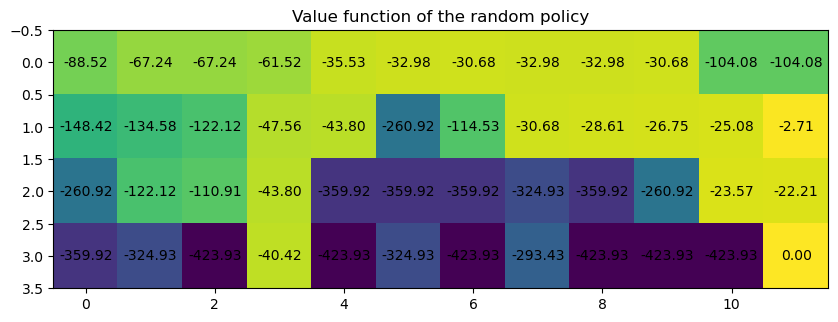

time: 378 ms (started: 2023-11-18 15:34:03 +01:00)


In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
plt.imshow(random_value_function.reshape(4, 12))
ax = plt.gca()
for (j,i),label in np.ndenumerate(random_value_function.reshape(4,12)):
    ax.text(i,j,f'{label:.2f}',ha='center',va='center')

plt.title('Value function of the random policy')

In [22]:
np.random.seed(102)
right_value_function = policy_evaluation(GoRightPolicy, epsilon, gamma, 100000)

time: 15.4 s (started: 2023-11-18 15:34:03 +01:00)


Text(0.5, 1.0, 'Value function of the "go right" policy')

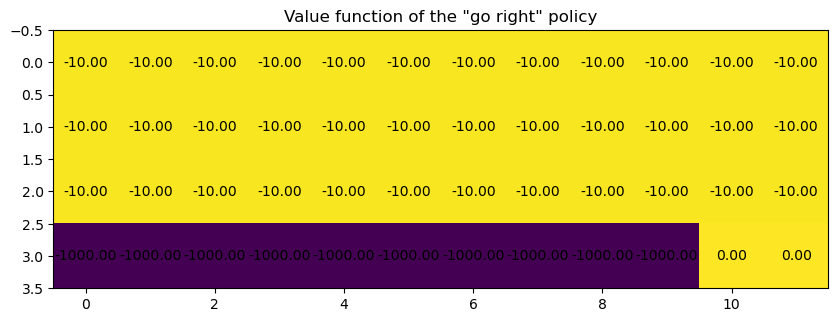

time: 360 ms (started: 2023-11-18 15:34:19 +01:00)


In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
plt.imshow(right_value_function.reshape(4, 12))
ax = plt.gca()
for (j,i),label in np.ndenumerate(right_value_function.reshape(4,12)):
    ax.text(i,j,f'{label:.2f}',ha='center',va='center')

plt.title('Value function of the "go right" policy')

In [24]:
np.random.seed(102)
down_value_function = policy_evaluation(np.array([2]*48), epsilon, gamma, max_iter)

time: 1.2 s (started: 2023-11-18 15:34:19 +01:00)


Text(0.5, 1.0, 'Value function of the "go down" policy')

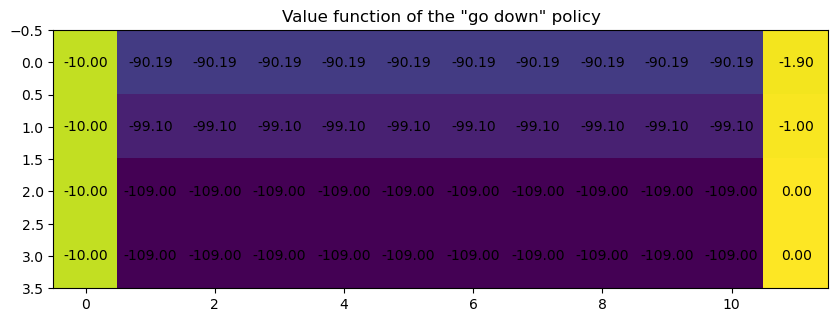

time: 317 ms (started: 2023-11-18 15:34:20 +01:00)


In [25]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
plt.imshow(down_value_function.reshape(4, 12))
ax = plt.gca()
for (j,i),label in np.ndenumerate(down_value_function.reshape(4,12)):
    ax.text(i,j,f'{label:.2f}',ha='center',va='center')

plt.title('Value function of the "go down" policy')

**Q.9 Build a policy improvement function**

In [26]:
def policy_improve(V, policy):
    policy_stable = True
    policy_values = np.zeros(nb_states, dtype=int)

    for s in range(nb_states):
        old_action = policy[s]
        imm_rewards = r[s, :]  # (4, ) vector of rewards when doing x action
        next_values = np.dot(P[s, :,], V)  # (4, 48)x(48,1)
        value_based_action = int(np.argmax(imm_rewards+gamma*next_values))
        if old_action != value_based_action:
            policy_stable = False

        policy_values[s] = value_based_action

    return policy_values, policy_stable

time: 843 µs (started: 2023-11-18 15:34:21 +01:00)


**Q.10 Using the two preceding functions, build the Policy Iteration algorithm**

In [27]:
def policy_iteration(epsilon, gamma, max_iter):
    policy = np.random.choice([0,1,2,3], size=(48,))
    stable = False
    while not stable:
        V = policy_evaluation(policy, epsilon, gamma, max_iter)
        policy, stable = policy_improve(V, policy)

    return policy

time: 961 µs (started: 2023-11-18 15:34:21 +01:00)


In [28]:
epsilon = 0.01
gamma = 0.9
max_iter = 10000
policy = policy_iteration(epsilon, gamma, max_iter)
print(policy.reshape(4,12))

[[1 1 1 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 1 1]]
time: 17.1 s (started: 2023-11-18 15:34:21 +01:00)


Text(0.5, 1.0, 'Value function of the found policy')

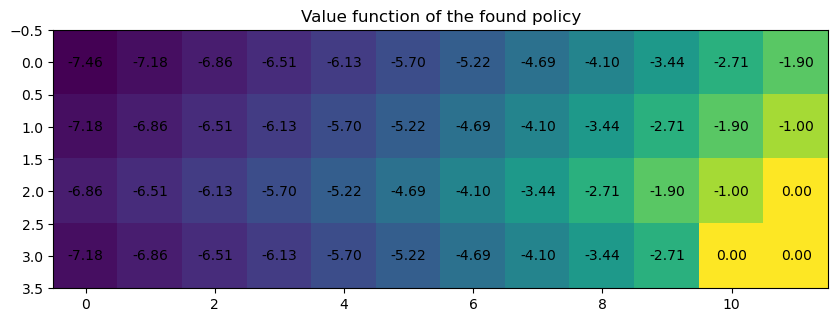

time: 1.52 s (started: 2023-11-18 15:34:38 +01:00)


In [29]:
opt_value_function = policy_evaluation(policy, epsilon, gamma, max_iter)

fig, ax = plt.subplots(1,1, figsize=(10,5))
plt.imshow(opt_value_function.reshape(4, 12))
ax = plt.gca()
for (j,i),label in np.ndenumerate(opt_value_function.reshape(4,12)):
    ax.text(i,j,f'{label:.2f}',ha='center',va='center')

plt.title('Value function of the found policy')

**Q.11 Test your obtained policy and compare it against random policies. Is it optimal ?** 

**Answer:** Yes it is the optimal policy.

In [80]:
def found_policy(state, action_space):
    return policy[state]

time: 313 µs (started: 2023-11-18 16:26:07 +01:00)


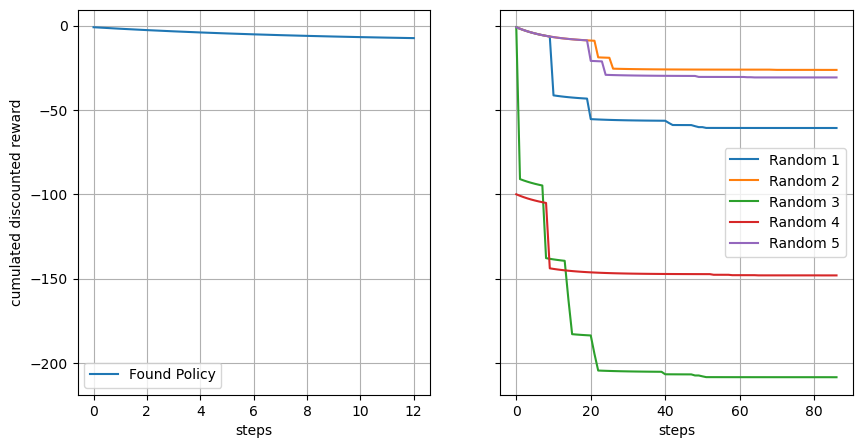

time: 376 ms (started: 2023-11-18 16:29:28 +01:00)


In [91]:
np.random.seed(42)
states, rewards = SimulateTrajectory(T, found_policy)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax1.plot(np.cumsum(rewards*np.array([gamma**t for t in range(len(rewards))])), label="Found Policy")
ax1.set_ylabel('cumulated discounted reward')
ax1.grid()
ax1.set_xlabel('steps')
ax1.legend()
for _ in range(5):
    States1, Rewards1 = SimulateTrajectory(T, RandomPolicy)
    ax2.plot(np.cumsum(Rewards1*np.array([gamma**t for t in range(len(Rewards1))])), label=f"Random {_+1}")
ax2.grid()
ax2.set_xlabel('steps')
ax2.legend()

plt.show()

### Value Iteration

**Q.12 Similarly to the Policy Iteration algorithm, build the Value Iteration Algorithm and test it.**

In [30]:
def value_iteration(epsilon, gamma, max_iter):
    V = -np.ones(nb_states)
    V[-1] = 0

    delta = 0

    for _ in range(max_iter):
        for s in range(nb_states):
            v = V[s]
            V[s] = np.max(r[s, :] +  gamma*np.dot(P[s, :, :], V))
            delta = max(delta, abs(v-V[s]))

        if delta < epsilon:
            break

    return V

time: 657 µs (started: 2023-11-18 15:34:39 +01:00)


In [32]:
value_star = value_iteration(epsilon, gamma, max_iter)

time: 4.79 s (started: 2023-11-18 15:35:19 +01:00)


Text(0.5, 1.0, 'Value function after value iteration')

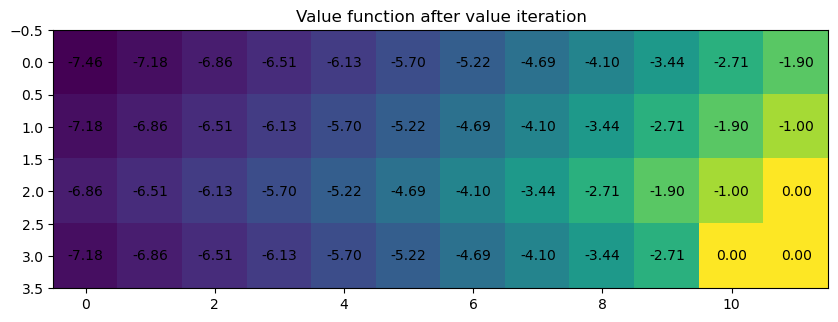

time: 368 ms (started: 2023-11-18 15:35:51 +01:00)


In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
plt.imshow(value_star.reshape(4, 12))
ax = plt.gca()
for (j,i),label in np.ndenumerate(value_star.reshape(4,12)):
    ax.text(i,j,f'{label:.2f}',ha='center',va='center')

plt.title('Value function after value iteration')

In [35]:
new_policy, _ = policy_improve(value_star, np.random.choice([0,1,2,3], size=(48,)))

time: 3.45 ms (started: 2023-11-18 15:38:20 +01:00)


In [36]:
print(new_policy.reshape(4,12))

[[1 1 1 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 1 1]]
time: 538 µs (started: 2023-11-18 15:38:26 +01:00)


**Note:** We found the same optimal policy and value, but it was much simpler to code and faster to execute. It seems like a good choice for this problem.

# Our first sampling algorithm

Now we don't have access to the Reward and Transitions table anymore ! We will have to explore to build our knowledge of an estimation of the action-value Q(s,a) along the way.

**Q.13 Read the pseudo-code for the Monte Carlo Exploring Starts algorithms. Describe briefly how the algorithm allows in theory to get a good policy.**

![Alt text](image.png)

This algorithm makes sense because we are essentially simulating a run in the environment many many times, and each time from a different state so that all of them have the chance to appear at different time steps. Then, we compute the cumulative reward for each (state, action) pair, in the earliest timestep it appears, which is the best estimate that we have for its Q. After this, we update the Q function with the mean of all the cumulative rewards we have seen, which will be the Monte Carlo part (approximating an expected value with an empirical mean). 

**Q.14 Why can this algorithm be not efficient ?**

It can definitely be more efficient in the Monte Carlo estimation of the expected value. Instead of keeping track of all the Returns seen so far, we can count how many episodes have been run to get the current estimation. Then, it is a matter of increasing the counts by one and updating the estimation with the new value. In mathematical terms:

$$
Q(S_t, A_t) \leftarrow  \frac{G + Q(S_t, A_t)(\text{counts}+1)}{\text{counts}+1} 
$$

**Q.15  Implement a Monte Carlo Exploring Starts algorithm.**

We will store action-value information in a table q[s,a] that will be updated at each episode. 

You will need :
- To store ```pi```, ```q[s,a]``` as tables and ```Returns(s,a)``` as a list of cumulative discounted rewards
- To reset the environment for each episode. 
- To use the ```step()``` method to act on the environment 
- To update your knowledge of q on the trajectory of the episode.
- To update the current policy given the update of q.


In [101]:
def monte_carlo_se(max_iter, episode_length):
    pi = np.random.choice([0,1,2,3], size=(48,))
    Q = np.zeros((nb_states, nb_actions))
    Counts = [[0 for _ in range(nb_actions)] for _ in range(nb_states)]

    for _ in range(max_iter):
        s = np.random.choice(range(nb_states))
        a = np.random.choice(range(nb_actions))

        states = [s]
        actions = [a]
        rewards = [r[s, a]]
        for step in range(episode_length):
            s = sample_next_state(P, s, a)
            if T[s] == 1:
                break
            
            a = pi[s]
            reward = r[s, a]

            states.append(s)
            actions.append(a)
            rewards.append(reward)

        G = 0
        for t in range(len(states)-1, -1, -1):
            G = gamma*G + rewards[t]
            s = states[t]
            a = actions[t]
            if (s, a) not in zip(states[:t], actions[:t]):
                Q[s, a] = G/(Counts[s][a]+1) + Counts[s][a]*Q[s, a]/(Counts[s][a]+1)
                Counts[s][a] += 1
                pi[s] = np.argmax(Q[s, :])


    return pi, Q

time: 2.22 ms (started: 2023-11-18 16:44:04 +01:00)


In [116]:
np.random.seed(10)
pi, q = monte_carlo_se(20000, 100)

time: 13.6 s (started: 2023-11-18 16:49:18 +01:00)


**Q.16 Visualize the obtained policy after training over some iterations and conclude**

In [117]:
pi.reshape(4,12)

array([[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2],
       [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 2],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])

time: 2.46 ms (started: 2023-11-18 16:50:01 +01:00)


We can see that this policy is able to reach the target but it's not optimal. For some states where it should go right, it goes up instead, making it take 4 more steps (2 where it goes up and another 2 to undo it). This comes from the stochasticity of the estimation, and probably with more iterations we would converge to the optimal policy. However, already with 20k iterations the algorithm is considerable slower than value iteration. Therefore, it is of high importance to consider if we have access to the transition matrix and the reward function, so we can use more efficient and deterministic methods. When this is not possible, it is possible that many more iterations will be needed, especially for more complex problems.

In [118]:
def found_policy(state, action_space):
    return pi[state]

time: 566 µs (started: 2023-11-18 16:50:06 +01:00)


Text(0.5, 0, 'steps')

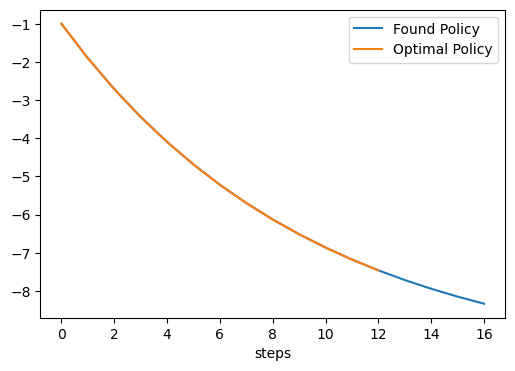

time: 242 ms (started: 2023-11-18 16:50:06 +01:00)


In [119]:
plt.figure(figsize=(6, 4))
# simulate policy
states, rewards = SimulateTrajectory(100, found_policy)
_, opt_rewards = SimulateTrajectory(100, OptimalPolicy)
plt.plot(np.cumsum(rewards*np.array([gamma**t for t in range(len(rewards))])), label="Found Policy")
plt.plot(np.cumsum(opt_rewards*np.array([gamma**t for t in range(len(opt_rewards))])), label="Optimal Policy")
plt.legend()
plt.xlabel('steps')